# Rozhodovací stromy: učení se z dat
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [58]:
import math
import pandas as pd
import numpy as np

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [59]:
data = pd.read_csv('adult-census.csv')
display(data.shape)
display(data.head())
display(data.info())
display(data.describe())
display(data.nunique()) # počet unikátních hodnot, defaultně ignoruje NaNs

(32561, 15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

### Chybějící hodnoty

  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [60]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## První pokus o použití rozhodovacího stromu implementovaného v `sklearn`

    

 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.
 * Naším cílem je pouze zjistit, jestli už máme data připravená k tomu, aby si s nimi tato implementace poradila.

In [61]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1] 

  * V knihovně `scikit-learn` mají modely jednotný interface (API).
  * Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné:

In [62]:
dt = DecisionTreeClassifier()
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')>

  * Model se pak "naučí" na datech pomocí metody `.fit()`. 
  * V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

In [63]:
# dt.fit(Xdata, ydata)

  * **Ajajaj, nefunguje to:** implementace rozhodovacího stromu v `sklearn` si neumí poradit s nečíselnými (nenumerickými) příznaky.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [64]:
### sem přijde Váš kód
edu = data[["education", "education.num"]].drop_duplicates()
edu.sort_values(by="education.num")

,education,education.num
1106,Preschool,1
26,1st-4th,2
27,5th-6th,3
3,7th-8th,4
197,9th,5
6,10th,6
16,11th,7
178,12th,8
0,HS-grad,9
2,Some-college,10


In [65]:
display(data.dtypes)
display(data.nunique())
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.

In [66]:
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
data.info()
# funguje to?
data["native.country"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null int8
fnlwgt            32561 non-null int64
education         32561 non-null int8
education.num     32561 non-null int64
marital.status    32561 non-null int8
occupation        32561 non-null int8
relationship      32561 non-null int8
race              32561 non-null int8
sex               32561 non-null int8
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null int8
income            32561 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


array([38, -1, 25, 11, 39,  2, 35, 18, 29, 37,  1, 34, 14, 32, 30, 19,  8,
       10, 21, 23, 16, 15,  4, 20,  0, 28, 26,  5, 13,  7, 17,  3, 12, 22,
        6,  9, 40, 33, 31, 24, 36, 27])

  * A teď to můžeme zkusit s `DecisionTreeClassifier` znovu!
  * Co se stalo s `NaN` položkami?

In [67]:
data.occupation.unique()
data.groupby(["occupation"]).size() # ve sloupci occupation bylo 1843 chybějících hodnot

occupation
-1     1843
 0     3770
 1        9
 2     4099
 3     4066
 4      994
 5     1370
 6     2002
 7     3295
 8      149
 9     4140
 10     649
 11    3650
 12     928
 13    1597
dtype: int64

**Chybějící hodnoty byly nahrazeny -1!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.

In [68]:
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1]
dt = DecisionTreeClassifier()
dt.fit(Xdata, ydata)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Učení stromu

  * Cílem je vytvořit rozhodovací strom, který bude předpovídat *income* daných osob.
  * Chceme také najít nejlepší hodnoty parametrů `max_depth` a `criterion` metody `DecisionTreeClassifier`. Takovýmto parametrům metody se říká *hyperparametery*.
  * Jak víme z přednášky, správný způsob ladění hyperparametrů vyžaduje rozdělení dat na trénovací, validační a testovací.
  * A samozřejmě v `sklearn` je na to balíček.

In [69]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xtest.shape)
display(ytest.shape)

(24420, 14)

(24420,)

(8141, 14)

(8141,)

In [70]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xval.shape)
display(yval.shape)

(18315, 14)

(18315,)

(6105, 14)

(6105,)

### Měření trénovací chyby pomocí klasifikační přesnosti

In [71]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [72]:
ypredicted = dt.predict(Xtrain)
ypredicted

array([0, 0, 0, ..., 0, 0, 1], dtype=int8)

In [73]:
(ytrain - ypredicted).value_counts(normalize=True)

0    0.999945
1    0.000055
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [74]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))

accuracy score (train): 0.999945


S testovacími daty to tak skvěle nedopadne:

In [75]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.817344


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [76]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

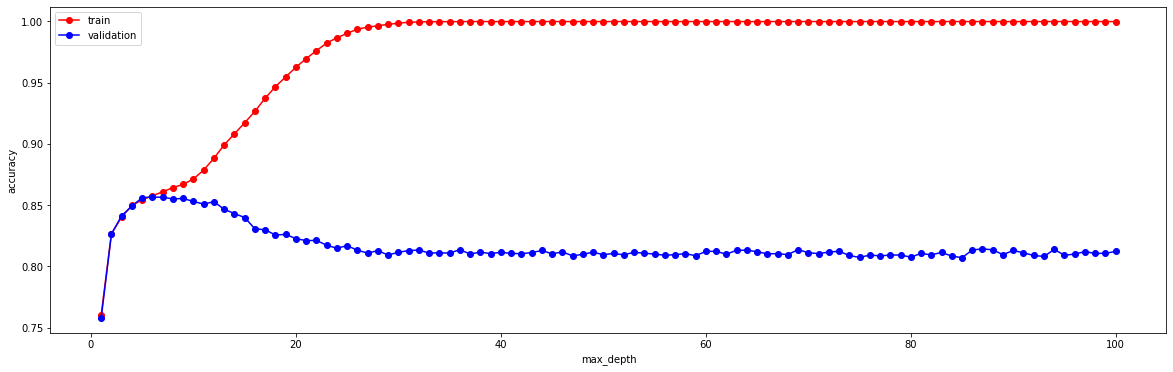

In [77]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [78]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

6

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [79]:
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.849773


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 100] a obě možné hodnoty `criterion`, tj. 200 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [88]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# just to see the result:
[param_comb[i] for i in range(2)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'}]

In [81]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

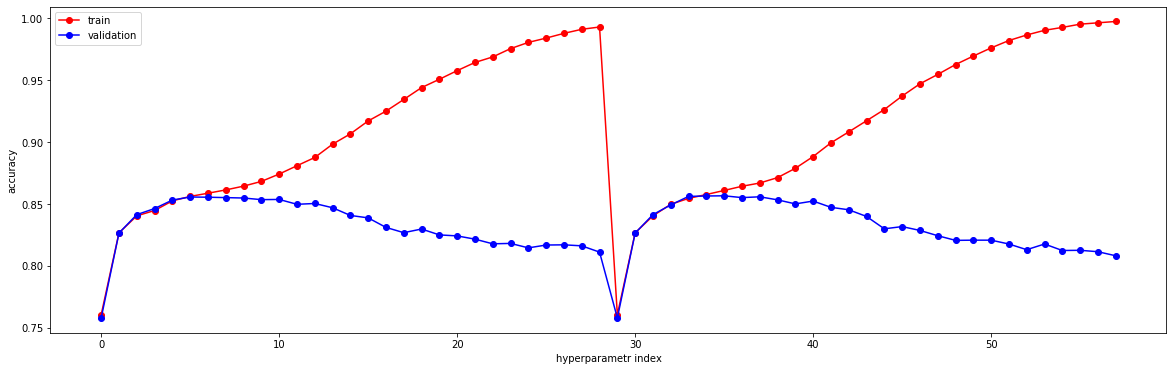

In [82]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [89]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 7, 'criterion': 'gini'}

In [84]:
dt = DecisionTreeClassifier(**best_params) # TOHOTO ŘÁDKU si všimněte: dvě hvězdišky jsou mocný nástroj
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.860988
accuracy score (validation): 0.856511
accuracy score (test): 0.850387


### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

In [115]:
titanic = pd.read_csv('titanic.csv', sep=';')
### sem přijde Váš kód

display(titanic.describe())
display(titanic.nunique())

titanic.info()

(132, 13)

,PassengerId,Survived,Pclass,Name,Sex,FootSize,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,34.0,33.0,0,0,110152,86.5000,B77,S
1,2,0,3,"Garfirth, Mr. John",male,NaN,NaN,0,0,358585,14.5000,NaN,S
2,3,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,NaN,41.0,0,0,SOTON/O2 3101272,7125.0000,NaN,S
3,4,1,3,"Barah, Mr. Hanna Assi",male,NaN,20.0,0,0,2663,7.2292,NaN,C
4,5,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,NaN,36.0,1,2,113760,120.0000,B96 B98,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
PassengerId    132 non-null int64
Survived       132 non-null int64
Pclass         132 non-null int64
Name           132 non-null object
Sex            132 non-null object
FootSize       6 non-null float64
Age            108 non-null float64
SibSp          132 non-null int64
Parch          132 non-null int64
Ticket         132 non-null object
Fare           132 non-null float64
Cabin          29 non-null object
Embarked       131 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 13.5+ KB


None

,PassengerId,Survived,Pclass,FootSize,Age,SibSp,Parch,Fare
count,132.000000,132.000000,132.000000,6.000000,108.000000,132.000000,132.000000,132.000000
mean,66.500000,0.356061,2.363636,27.500000,28.590278,0.537879,0.416667,1856.376009
std,38.249183,0.480658,0.840508,12.308534,14.393335,1.400138,0.819995,5863.540945
min,1.000000,0.000000,1.000000,12.000000,0.420000,0.000000,0.000000,0.000000
25%,33.750000,0.000000,2.000000,18.250000,18.750000,0.000000,0.000000,8.011450
50%,66.500000,0.000000,3.000000,29.000000,28.000000,0.000000,0.000000,19.004150
75%,99.250000,1.000000,3.000000,33.750000,39.000000,1.000000,1.000000,56.621850
max,132.000000,1.000000,3.000000,45.000000,74.000000,8.000000,5.000000,31275.000000


PassengerId    132
Survived         2
Pclass           3
Name           132
Sex              2
FootSize         6
Age             54
SibSp            6
Parch            5
Ticket         123
Fare            80
Cabin           27
Embarked         3
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
PassengerId    132 non-null int64
Survived       132 non-null int64
Pclass         132 non-null int64
Name           132 non-null object
Sex            132 non-null object
FootSize       6 non-null float64
Age            108 non-null float64
SibSp          132 non-null int64
Parch          132 non-null int64
Ticket         132 non-null object
Fare           132 non-null float64
Cabin          29 non-null object
Embarked       131 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 13.5+ KB


In [102]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xtitanic = titanic.iloc[:,:-1]
ytitanic = titanic.iloc[:,-1] 

In [124]:
titanicedu = titanic[["Survived", "Sex", "Pclass"]].drop_duplicates()
titanicedu.sort_values(by="Survived")

,Survived,Sex,Pclass
1,0,male,3
7,0,male,1
8,0,female,3
13,0,female,2
32,0,male,2
0,1,female,1
3,1,male,3
15,1,female,2
18,1,female,3
43,1,male,1


# Jak vykreslit strom  

In [86]:
simple_data = pd.read_csv('simple_data.csv', sep=';') # data z přednášky
display(simple_data.head(16)) 
dts = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dts.fit(simple_data.iloc[:,1:],simple_data['T'])

,T,F1,F2,F3
0,1,1,0,0
1,1,0,1,1
2,1,1,0,0
3,1,1,1,1
4,0,0,0,1
5,0,0,1,0
6,0,0,0,1
7,0,1,1,0


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

[Text(279.0, 453.0, 'F1 <= 0.5\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]\nclass = y[0]'),
 Text(139.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = y[0]'),
 Text(69.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = y[0]'),
 Text(209.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]'),
 Text(418.5, 271.8, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]\nclass = y[1]'),
 Text(348.75, 90.59999999999997, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = y[1]'),
 Text(488.25, 90.59999999999997, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]')]

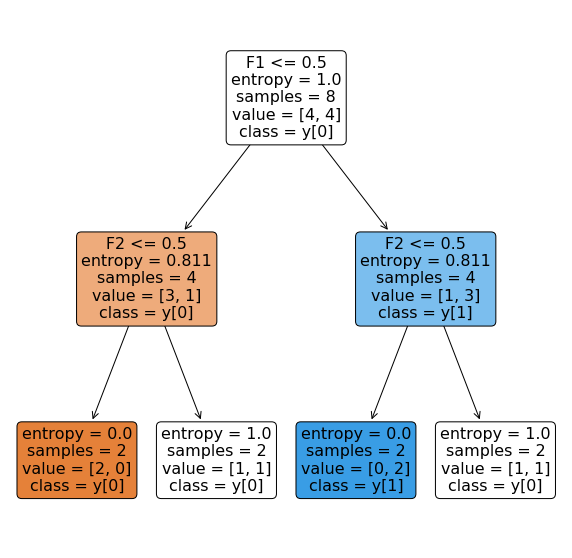

In [87]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(10,10))
plot_tree(dts, filled=True, feature_names=simple_data.iloc[:,1:].columns, class_names=True, rounded=True)


# pro titanik
#plt.figure(figsize=(20,25))
#plot_tree(dt, filled=True, feature_names=Xdata.columns, class_names=["not survived", "survived"], rounded=True)